In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from pathlib import Path
import glob
import re

from plaid.evaluation import batch_rmsd_calculation, batch_rmspd_from_pdb_paths, run_tmalign
from plaid.utils import read_sequences_from_fasta, calc_sequence_recovery

import re
import wandb

# Naturalness

In [35]:
import glob
gen_samples = glob.glob("/data/lux70/plaid/artifacts/samples/5j007z42/100_200_300/**/generated/structures/*pdb", recursive=True)
gen_samples.sort()
print(len(gen_samples))
print(gen_samples[:4])

from plaid.utils import extract_avg_b_factor_per_residue

all_plddts = {}

for pdb_path in gen_samples:
    plddts = extract_avg_b_factor_per_residue(pdb_path)
    all_plddts[pdb_path] = np.mean(plddts)

384
['/data/lux70/plaid/artifacts/samples/5j007z42/100_200_300/ive5gowq/generated/structures/sample0.pdb', '/data/lux70/plaid/artifacts/samples/5j007z42/100_200_300/ive5gowq/generated/structures/sample1.pdb', '/data/lux70/plaid/artifacts/samples/5j007z42/100_200_300/ive5gowq/generated/structures/sample10.pdb', '/data/lux70/plaid/artifacts/samples/5j007z42/100_200_300/ive5gowq/generated/structures/sample100.pdb']


Text(0.5, 1.0, 'pLDDT for sequences of lengths {100, 200, 300}')

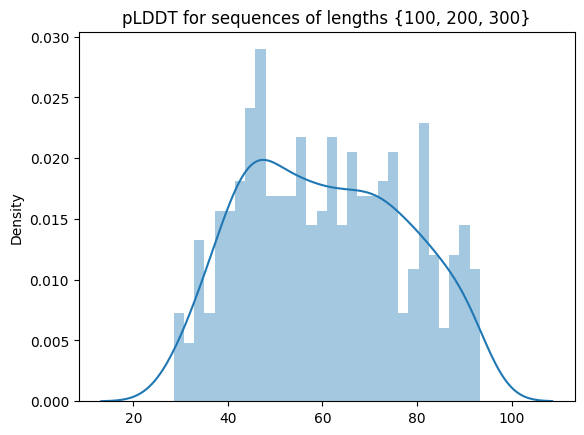

In [37]:
# _ = plt.hist(all_plddts, bins=30)
sns.distplot(list(all_plddts.values()),bins=30)
plt.title("pLDDT for sequences of lengths {100, 200, 300}")

In [38]:
from plaid.utils import read_sequences_from_fasta
seqs = []
fastas = glob.glob("/data/lux70/plaid/artifacts/samples/5j007z42/100_200_300/**/generated/sequences.fasta")
for fasta in fastas:
    seqd = read_sequences_from_fasta(fasta)
    seqs.extend(list(seqd.values()))
print(len(seqs))

384


In [39]:
from plaid.evaluation import RITAPerplexity
rita_pl = RITAPerplexity()
pls = [rita_pl.calc_perplexity(s) for s in seqs]
print(len(pls))

384


In [40]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size']=8

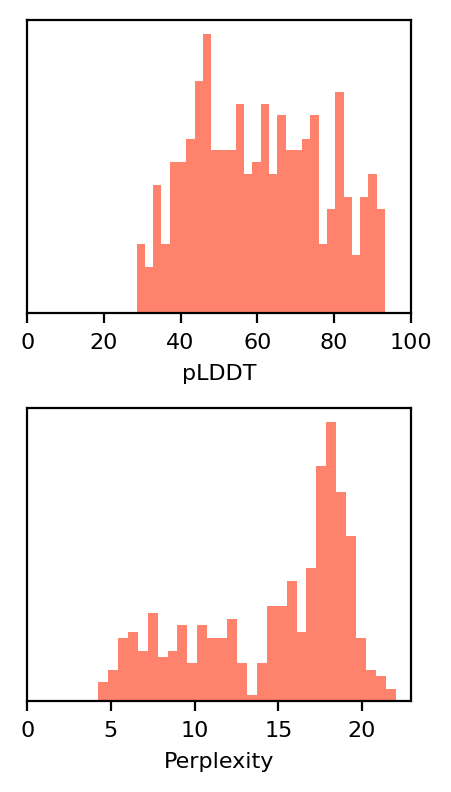

In [41]:
sty_kwargs = {"alpha":0.8, "color":"tomato"}

fig, axs = plt.subplots(2,1, figsize=(2.3,4),dpi=200)
axs[0].hist(list(all_plddts.values()),bins=30,**sty_kwargs)
axs[0].set_ylabel("")
axs[0].set_yticks([])
axs[0].set_xlabel("pLDDT")
axs[0].set_xticks(range(0,101,20))

axs[1].hist(pls,bins=30,**sty_kwargs)
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[1].set_xlabel("Perplexity")
axs[1].set_xticks(range(0,24,5))


plt.tight_layout()
plt.show()

## Multiflow

In [6]:
import glob
gen_samples = glob.glob("/data/lux70/plaid/baselines/multiflow/by_length/length_*/sample_*/sample.pdb", recursive=True)
gen_samples.sort()
print(len(gen_samples))
print(gen_samples[:4])

from plaid.utils import extract_avg_b_factor_per_residue

all_plddts = {}

for pdb_path in gen_samples:
    plddts = extract_avg_b_factor_per_residue(pdb_path)
    all_plddts[pdb_path] = np.mean(plddts)

96
['/data/lux70/plaid/baselines/multiflow/by_length/length_100/sample_0/sample.pdb', '/data/lux70/plaid/baselines/multiflow/by_length/length_100/sample_1/sample.pdb', '/data/lux70/plaid/baselines/multiflow/by_length/length_100/sample_10/sample.pdb', '/data/lux70/plaid/baselines/multiflow/by_length/length_100/sample_11/sample.pdb']


In [11]:
from plaid.utils import parse_sequence_from_structure
import warnings
warnings.filterwarnings('ignore')

all_sequences = {}
for pdb_path in gen_samples:
    with open(pdb_path, "r") as f:
        pdbstr = f.read()
    sequence = parse_sequence_from_structure(pdbstr)
    all_sequences[pdb_path] = sequence

In [15]:
# from plaid.utils import write_to_fasta

# write_to_fasta(
#     list(all_sequences.values()), 
#     "/data/lux70/plaid/baselines/multiflow/by_length/sequences.fasta", 
#     list(all_sequences.keys())
# )

Wrote 96 sequences to /data/lux70/plaid/baselines/multiflow/by_length/sequences.fasta.


In [17]:
from plaid.evaluation import RITAPerplexity
rita_pl = RITAPerplexity()
pls = [rita_pl.calc_perplexity(s) for s in list(all_sequences.values())]
print(len(pls))

96


In [21]:
multiflow_perplexity = np.array(pls)

In [42]:
multiflow_perplexity.shape

(96,)

In [43]:
# with open("/data/lux70/plaid/baselines/multiflow/by_length/perplexity.pkl", "wb") as f:
#     np.save(f, multiflow_perplexity, allow_pickle=True)

# Consistency

In [135]:
# grab all generated structures

# ive5gowq  o9cma5q0  xt5ba20h

import glob
gen_samples = glob.glob("/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/**/generated/structures/*pdb", recursive=True)
gen_samples.sort()
print(len(gen_samples))
print(gen_samples[:4])

inverse_gen_pdbs = glob.glob("/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/**/inverse_generated/structures/*pdb", recursive=True)
inverse_gen_pdbs.sort()
print(len(inverse_gen_pdbs))
print(inverse_gen_pdbs[:4])

384
['/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/generated/structures/sample0.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/generated/structures/sample1.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/generated/structures/sample10.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/generated/structures/sample100.pdb']
384
['/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/inverse_generated/structures/sequence_0.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/inverse_generated/structures/sequence_1.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/inverse_generated/structures/sequence_10.pdb', '/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/ive5gowq/inverse_generated/structures/sequence_100.pdb']


In [136]:
ccrmsd = batch_rmsd_calculation(inverse_gen_pdbs, gen_samples)
cctm = [run_tmalign(p1,p2) for (p1,p2) in zip(inverse_gen_pdbs, gen_samples)]

In [148]:
from plaid.evaluation._structure_metrics import calculate_rmsd

ccrmsd_allatom = [calculate_rmsd(p1,p2,ca_only=False) for (p1, p2) in zip(inverse_gen_pdbs, gen_samples)]

In [140]:
import glob
phantom_gen_samples = glob.glob("/data/lux70/plaid/artifacts/samples/by_length/5j007z42/f2219_o3617/ddim/**/phantom_generated/structures/*pdb", recursive=True)
phantom_gen_samples.sort()

scrmsd = batch_rmsd_calculation(inverse_gen_pdbs, phantom_gen_samples)
sctm = [run_tmalign(p1,p2) for (p1,p2) in zip(inverse_gen_pdbs, phantom_gen_samples)]

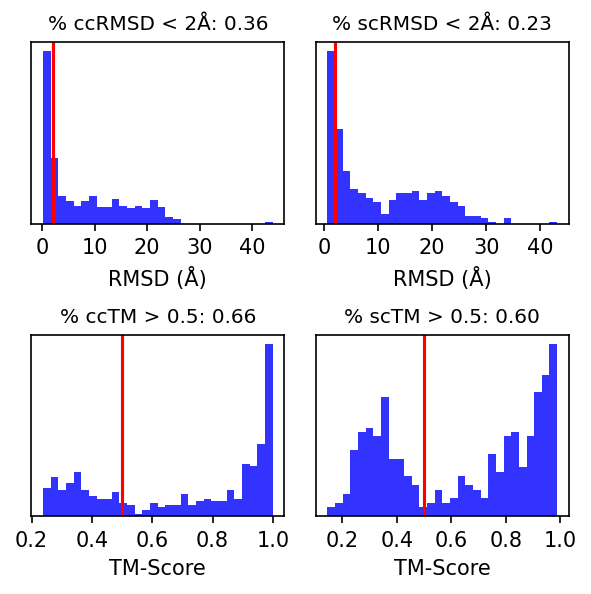

In [228]:
fig, axs = plt.subplots(2,2, figsize=(4,4))


ccrmsd = np.array(ccrmsd)
ccrmsd_thres = ((ccrmsd < 2).sum() / len(ccrmsd))

sty_kwargs={"alpha":0.8,"color":"blue","bins":30}




# RMSDs
axs[0][0].hist(ccrmsd,**sty_kwargs)
axs[0][0].set_title(f"% ccRMSD < 2Å: {ccrmsd_thres:.2f}")

scrmsd = np.array(scrmsd)
scrmsd_thres = (scrmsd < 2).sum() / len(scrmsd)

axs[0][1].hist(scrmsd,**sty_kwargs)
axs[0][1].set_title(f"% scRMSD < 2Å: {scrmsd_thres:.2f}")

for j in range(2):
    axs[0][j].axvline(x=2,color="red")
    axs[0][j].set_xlabel("RMSD (Å)")
    axs[0][j].set_yticks([])


## TMs
cctm_thres = (np.array(cctm) > 0.5).sum() / len(cctm)
sctm_thres = (np.array(sctm) > 0.5).sum() / len(sctm)

axs[1][0].hist(cctm,**sty_kwargs)
axs[1][0].set_title(f"% ccTM > 0.5: {cctm_thres:.2f}")

axs[1][1].hist(sctm,**sty_kwargs)
axs[1][1].set_title(f"% scTM > 0.5: {sctm_thres:.2f}")

for j in range(2):
    axs[1][j].axvline(x=0.5,color="red")
    axs[1][j].set_xlabel("TM-Score")
    axs[1][j].set_yticks([])

plt.tight_layout()
plt.show()